In [1]:
import numpy as np
import pandas as pd
from util import contraction
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import backend as K
from keras.layers import Input, CuDNNLSTM, Embedding, Dense, Concatenate, TimeDistributed
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from util import attention
from matplotlib import pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
      for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)


nltk.download("stopwords")

data = pd.read_csv("./Data/dblp-v10.csv", nrows=75000)

data.drop_duplicates(subset=["abstract"], inplace=True)
data.dropna(axis=0, inplace=True)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\Andrew\AppData\Local\Temp\ipykernel_22552\796914484.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['cleaned_summary'].replace('', np.nan, inplace=True)


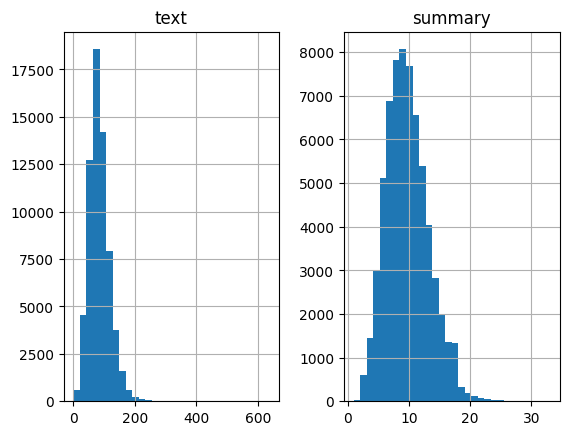

In [2]:

#Preprocessing
stop_words = set(stopwords.words('english'))
def clean_text(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction.contraction_mapping[t] if t in contraction.contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]

    cleaned_text = []
    for i in tokens:
        if len(i)>=3:
            cleaned_text.append(i)
    return (" ".join(cleaned_text)).strip()

def clean_summary(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction.contraction_mapping[t] if t in contraction.contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = newString.split()

    cleaned_text = []
    for i in tokens:
        if len(i)>1:
            cleaned_text.append(i)
    return " ".join(cleaned_text)

cleaned_text = []
for i in data['abstract']:
    cleaned_text.append(clean_text(i))
cleaned_summary = []
for i in data['title']:
    cleaned_summary.append(clean_summary(i))

data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: '_START_' + x + '_END_')

text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

max_len_text = 200 
max_len_summary = 20
latent_dim = 500

x_tr, x_val, y_tr, y_val = train_test_split(data['cleaned_text'], data['cleaned_summary'], test_size=0.1, random_state=0, shuffle=True);

#Tokenizers
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

x_tr = x_tokenizer.texts_to_sequences(x_tr)
x_tr = pad_sequences(x_tr, maxlen=max_len_text, padding='post')
x_val = x_tokenizer.texts_to_sequences(x_val)
x_val = pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size = len(x_tokenizer.word_index)+1

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

y_tr = y_tokenizer.texts_to_sequences(y_tr)
y_tr = pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val = y_tokenizer.texts_to_sequences(y_val)
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index)+1


Epoch 1/50
914/914 [==============================] - 275s 276ms/step - loss: 3.5899 - val_loss: 3.1869
Epoch 2/50
914/914 [==============================] - 252s 276ms/step - loss: 3.1313 - val_loss: 2.9548
Epoch 3/50
914/914 [==============================] - 253s 277ms/step - loss: 2.9237 - val_loss: 2.8289
Epoch 4/50
914/914 [==============================] - 253s 277ms/step - loss: 2.7730 - val_loss: 2.7743
Epoch 5/50
914/914 [==============================] - 253s 277ms/step - loss: 2.6441 - val_loss: 2.7351
Epoch 6/50
914/914 [==============================] - 253s 276ms/step - loss: 2.5229 - val_loss: 2.7108
Epoch 7/50
914/914 [==============================] - 252s 276ms/step - loss: 2.4115 - val_loss: 2.7254
Epoch 8/50
914/914 [==============================] - 252s 276ms/step - loss: 2.3019 - val_loss: 2.7351
Epoch 8: early stopping


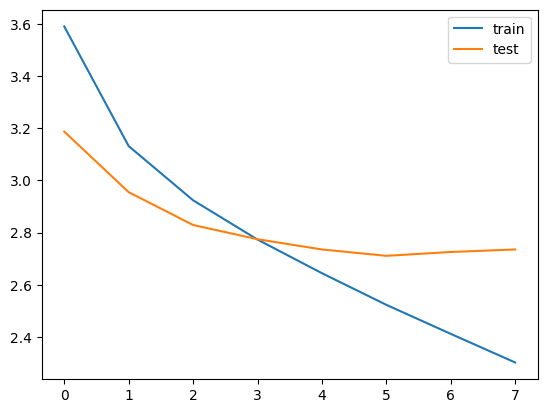

In [11]:

K.clear_session()

encoder_inputs = Input(shape=(max_len_text))
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

encoder_lstm1 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# attn_out = AdditiveAttention()([encoder_outputs, decoder_outputs])

attn_layer = attention.AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_input = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, attn_out])

decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
es = EarlyStopping(monitor="val_loss", patience=2, mode='auto', verbose=1)
history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], epochs=50, callbacks=[es], batch_size=64, validation_data=([x_val, y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))
model.save("./seq2seq.keras")

plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [4]:
#testing
# print(np.asarray(dec_emb_layer.get_weights()).shape)

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

def build_models(loaded_model):
    encoder_inputs = Input(shape=(max_len_text))
    embedding = Embedding(x_voc_size, latent_dim, trainable=True)
    enc_emb = embedding(encoder_inputs)

    encoder_lstm1 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    encoder_lstm2 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    encoder_lstm3 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

    embedding.set_weights(loaded_model.layers[1].get_weights())
    encoder_lstm1.set_weights(loaded_model.layers[2].get_weights())
    encoder_lstm2.set_weights(loaded_model.layers[4].get_weights())
    encoder_lstm3.set_weights(loaded_model.layers[6].get_weights())

    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

    decoder_inputs = Input(shape=(None,))
    dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)
    dec_emb = dec_emb_layer(decoder_inputs)

    decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

    attention_layer = attention.AttentionLayer(name='attention_layer')
    attn_out, attn_states = attention_layer([decoder_hidden_state_input, decoder_outputs]) 

    decoder_concat_input = Concatenate(axis=-1, name="concat_layer")([decoder_outputs, attn_out])

    decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_concat_input)

    dec_emb_layer.set_weights(loaded_model.layers[5].get_weights())
    decoder_lstm.set_weights(loaded_model.layers[7].get_weights())
    attention_layer.set_weights(loaded_model.layers[8].get_weights())
    decoder_dense.set_weights(loaded_model.layers[10].get_weights())

    encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
    decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], [decoder_outputs] + [decoder_fwd_state, decoder_back_state])
    return encoder_model, decoder_model

def decode_sequence(input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

loaded_model = tf.keras.models.load_model("seq2seq.keras", custom_objects={"AttentionLayer": attention.AttentionLayer})
encoder, decoder = build_models(loaded_model)

print(loaded_model.layers)
print("Enter a sentence")
x = input()
print("Input: " + x)
cleaned_text = [clean_text(x)]
cleaned_text = x_tokenizer.texts_to_sequences(cleaned_text)
cleaned_text = pad_sequences(cleaned_text, maxlen=max_len_text, padding='post')
print("Predicted summary:",decode_sequence(np.asarray(cleaned_text[0]).reshape(1,max_len_text), encoder, decoder))


[<keras.engine.input_layer.InputLayer object at 0x0000019C2DF15460>, <keras.layers.core.embedding.Embedding object at 0x0000019C2DF156A0>, <keras.layers.rnn.cudnn_lstm.CuDNNLSTM object at 0x0000019C2DF15190>, <keras.engine.input_layer.InputLayer object at 0x0000019C2DF15400>, <keras.layers.rnn.cudnn_lstm.CuDNNLSTM object at 0x0000019C15491EB0>, <keras.layers.core.embedding.Embedding object at 0x0000019C25A08EB0>, <keras.layers.rnn.cudnn_lstm.CuDNNLSTM object at 0x0000019C2DF29790>, <keras.layers.rnn.cudnn_lstm.CuDNNLSTM object at 0x0000019C2CD19D60>, <util.attention.AttentionLayer object at 0x0000019C2CCF0250>, <keras.layers.merging.concatenate.Concatenate object at 0x0000019C5AF46910>, <keras.layers.rnn.time_distributed.TimeDistributed object at 0x0000019C25A08460>]
Enter a sentence
Input: It has been proposed that single nucleotide polymorphisms (SNPs) discovered by genome-wide association studies (GWAS) account for only a small fraction of the genetic variation of complex traits in 